In [61]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [44]:
log = "sample.txt"

In [45]:
START_LINE = "START LINE"
TAG = "MainAcitvity"
CLEAR = "CLEAR"

FIELD_TIMESTAMP = "timestamp"
FIELD_MAX_SPEED = "max_speed"
FIELD_HEIGHT_ON_MAX_SPEED = "height_on_max_speed"
FIELD_MAX_HEIGHT = "max_height"
FIELD_LINE_TYPE = "line_type"
FIELD_TRIAL = "trial"
FIELD_SPEED = "speed"
FIELD_HEIGHT = "height"
FIELD_ORDER = [FIELD_TRIAL, FIELD_TIMESTAMP, FIELD_LINE_TYPE, FIELD_SPEED, FIELD_HEIGHT]

In [203]:
class LogParser:
    def __init__(self):

        self.is_running = False
        self.timestamp = ""
        self.line_type = ""
        self.measures = list()
        self.records = list()
        self.trial = 0
        self.result = None

    def start(self, line: str):
        print(f"start() - {line}")
        self.measures.clear()

        self.is_running = True
        self.line_type = line.split()[-1]
        self.timestamp = " ".join(line.split()[:2])
        self.trial = self.trial+1
    
    def clear(self) -> pd.DataFrame:
        # print("clear()")
        self.is_running = False
        df = pd.DataFrame(self.measures)
        # display(df.head())

        df[FIELD_TRIAL] = self.trial
        df[FIELD_TIMESTAMP] = self.timestamp
        df[FIELD_LINE_TYPE] = self.line_type
        
        return df
    
    
    def parse(self, logfile: str) -> pd.DataFrame:
        with open(logfile) as f:
            lines = f.readlines()
        
        for line in lines:
            # print(line)
            line = line.strip()
            if TAG not in line:
                continue
            # print(line)
            if START_LINE in line:
                self.start(line)
                continue
            if CLEAR in line:
                self.records.append(self.clear())
                continue
    
            # print(self.is_running)
            if not self.is_running:
                continue    
            tokens = line.split(",")
            # print(len(tokens))
            if len(tokens) != 3:
                continue
            speed = float(tokens[1].strip().split(":")[1])
            height = float(tokens[2].strip().split(":")[1]) 
            self.measures.append(dict(
                speed=speed, height=height, seq=len(self.measures)))

        self.result = pd.concat(self.records)[FIELD_ORDER]
        return self.result

    def summary(self):
        summary = self.result.groupby("trial", sort=False).apply(lambda x: pd.Series(
            dict(
                trial = x.name,
                line_type = x.line_type.values[0],
                min_height=x.height.min(), 
                # height_on_max_speed=x.loc[x.speed.idxmax(), "height"]
            )))
        return summary
        
    def plot(self, n:int=40, ncols:int=4):
        nrows = int(np.floor(n / ncols))
        _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,4*nrows), sharey=True)
        
        data = pd.concat([
            self.result.line_type,
            self.result.trial,
            pd.DataFrame(
                MinMaxScaler((0,1)).fit_transform(self.result[["speed", "height"]]),
                index=df.index,
                columns=["speed", "height"]
            )], axis=1)
        
        # data.info()
        for i in range(n):
            trial = i+1
            d = data.loc[data.trial == trial]
            if len(d) < 1:
                continue
            r = i // ncols
            c = i % ncols
            height = df.loc[df.trial==trial, "height"].min()
            speed =  df.loc[df.trial==trial, "speed"].min()
            ax[r][c].scatter(d.index, d["speed"], label="speed" )
            ax[r][c].scatter(d.index, d["height"], label="height")
            ax[r][c].set_title(f"Trial:{trial}({d.line_type.values[0]}) - {height}/{speed}")
            ax[r][c].legend()
        plt.tight_layout()
        # plt.legend()

In [204]:
parser = LogParser()
df = parser.parse("250603.txt")

start() - 2025-06-03 19:28:06.814 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:28:27.703 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:28:39.406 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:28:51.490 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:28:52.343 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:29:00.940 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:29:11.902 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:29:23.853 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:29:40.319 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:29:54.496 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:30:05.526 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:30:08.849 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:30:31.596 MainAcitvity             I  START LINE 1
start() - 2025-06-03 19:3

In [205]:
df.to_csv("measures.csv")

In [206]:
summary = parser.summary()
summary.to_csv("summary.csv")

/tmp/ipykernel_3007/4084101186.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = self.result.groupby("trial", sort=False).apply(lambda x: pd.Series(


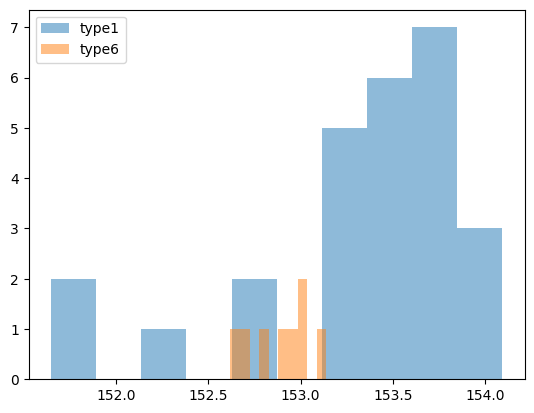

In [215]:
plt.hist( summary.loc[summary.line_type=="1", "min_height"], label="type1", alpha=.5)
plt.hist( summary.loc[summary.line_type=="6", "min_height"], label="type6", alpha=.5)
plt.legend()

In [207]:
stats.ttest_ind(
    summary.loc[summary.line_type=="1", "min_height"],
    summary.loc[summary.line_type=="6", "min_height"]
)

TtestResult(statistic=np.float64(1.8885641374040132), pvalue=np.float64(0.06804385779315104), df=np.float64(32.0))

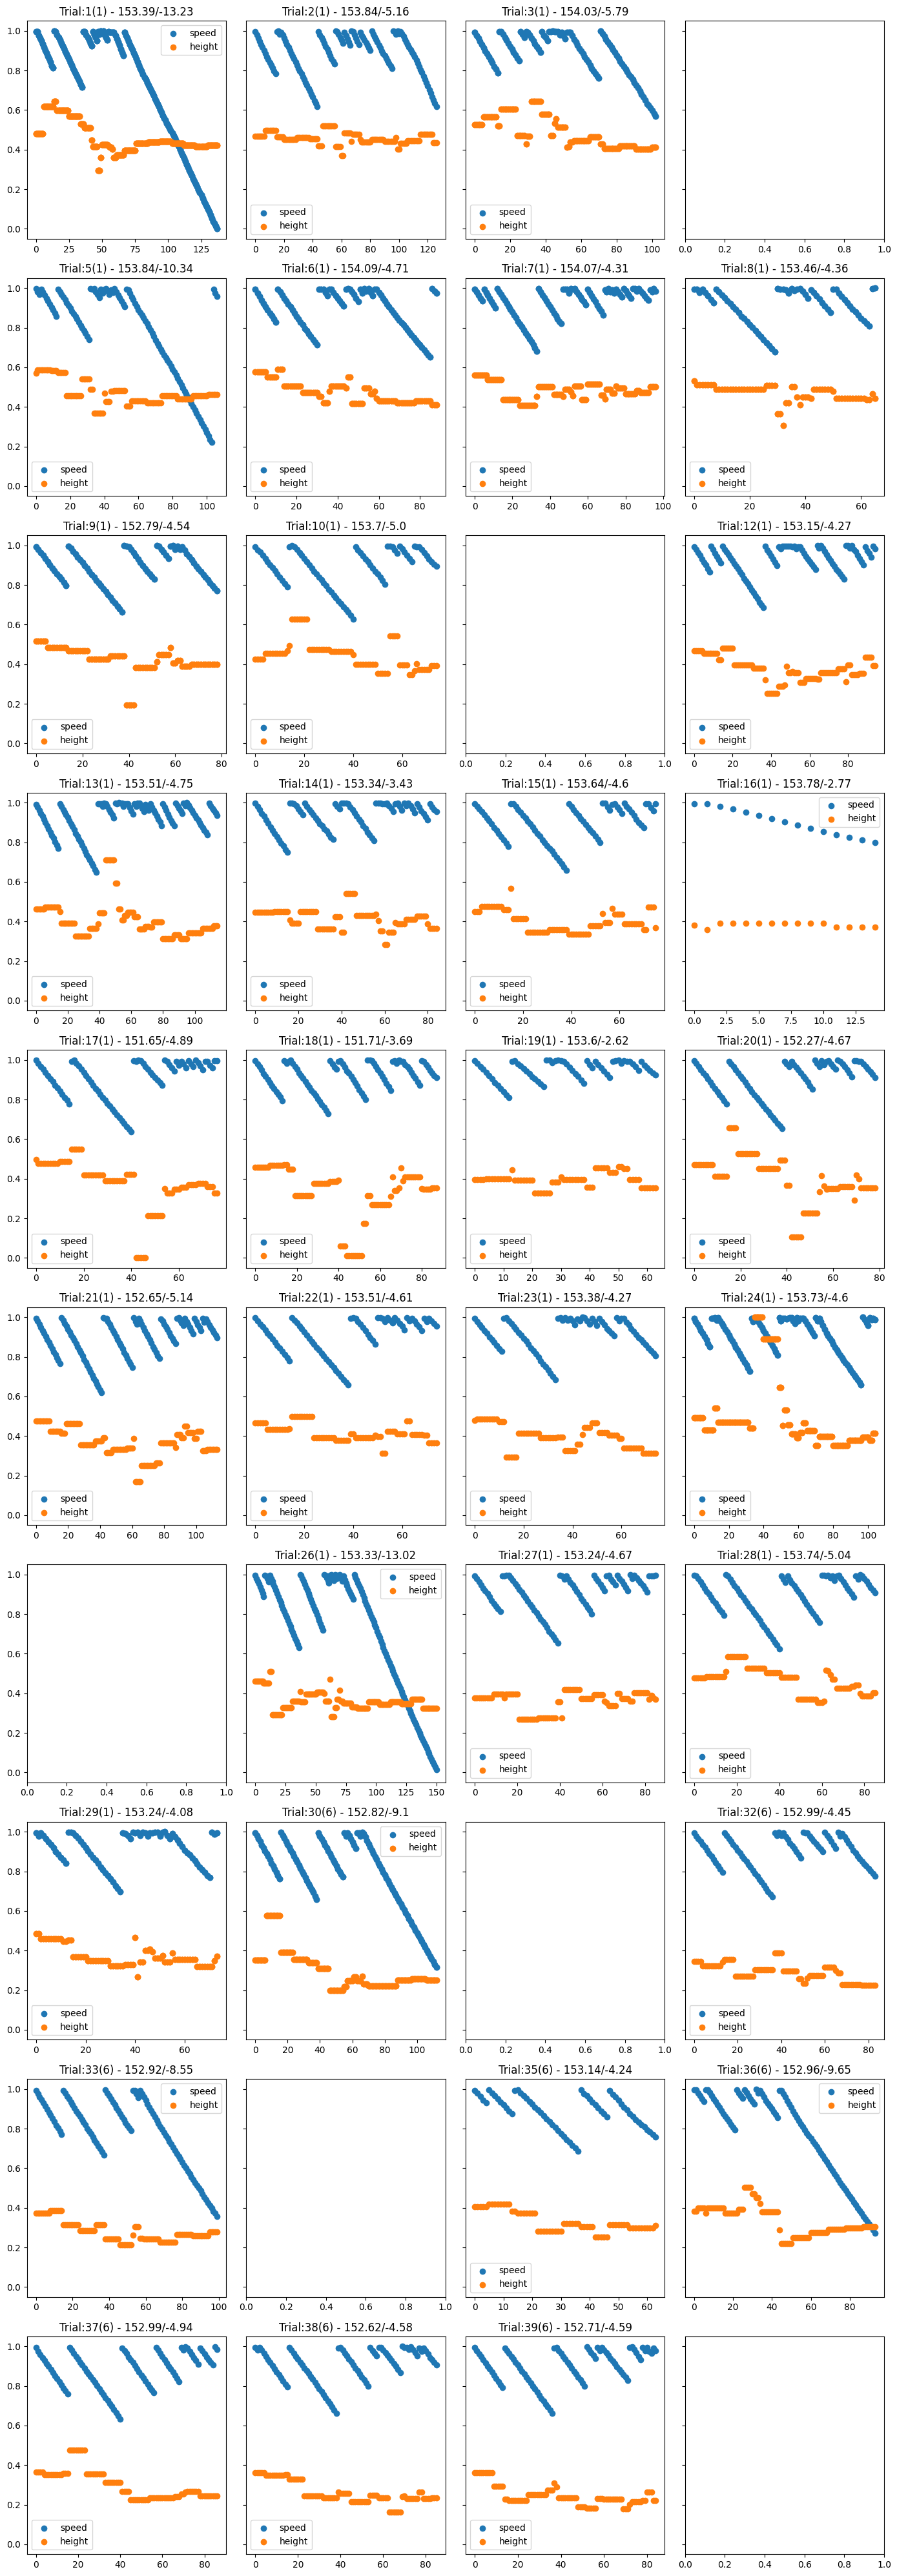

In [208]:
parser.plot()